Utilisation de pytesseract, librairie qui utilise tesseract-OCR de Google.
Comme pour PaddleOCR, il est nécéssaire d'avoir open-cv installer.

Les résultats semblent être plus précis qu'avec PaddleOCR pour les mots, pour les nombres PaddleOCR semblent être plus performant.

Doc : https://pypi.org/project/pytesseract/
Tuto : https://nanonets.com/blog/ocr-with-tesseract/



In [30]:
import cv2 
import pandas as pd
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

In [31]:
# Chargement de l'image dont on veut extraire les données
img = cv2.imread(r"C:\Users\Administrateur\Desktop\deep_learning\img_detect\blood.png")

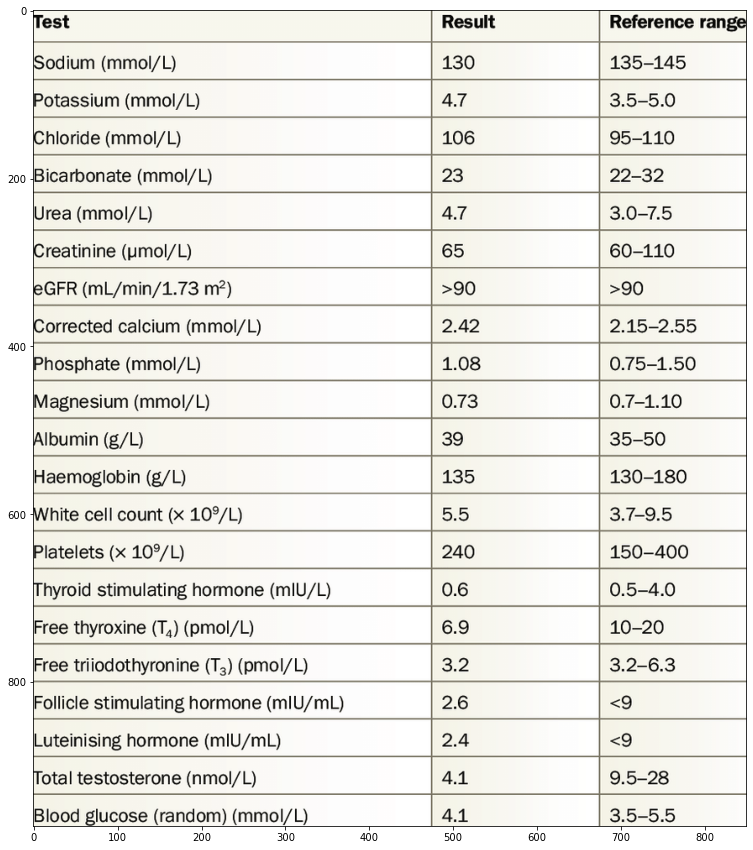

In [33]:
# Voici l'image 
plt.figure(figsize=(15,15))
plt.imshow(img)

In [19]:
# différentes options dispo avec pytesseract 
# pour plus de détails : https://muthu.co/all-tesseract-ocr-options/
# dans la partie "all tesseract options"
# oem = OCR engine mode, valeurs possible 0 à 3
# psm = page segmentation mode, valeurs possible 0 à 13
custom_config = r'--oem 3 --psm 6'

# beaucoup de paramètres disponibles, tel que la langue etc..
#  lang="fra" pour le français
# lang="eng+fra" => plusieurs langues en même temps (impossible sur paddleOCR)
# retourne le texte sous forme de string avec \n à la place des retours à la ligne
# moins pratique que paddleOCR pour la manipulation de données
pytesseract.image_to_string(img, config=custom_config).split("\n")

# Pas d'erreur au niveau des mots, par contre il manque toute la colonne "Result",
# il faut tester avec d'autres valeurs pour --psm 
# essayer d'autres langues

['Test Result Reference range',
 'Sodium (mmol/L) 135-145',
 'Potassium (mmol/L) 3.5-5.0',
 'Chloride (mmol/L) 95-110',
 'Bicarbonate (mmol/L) 22-32',
 'Urea (mmol/L) 3.0-7.5',
 'Creatinine (umol/L) 60-110',
 'eGFR (mL/min/1.73 m?) >90',
 'Corrected calcium (mmol/L) 2.15-2.55',
 'Phosphate (mmol/L) 0.75-1.50',
 'Magnesium (mmol/L) 0.7-1.10',
 'Albumin (g/L) 35-50',
 'Haemoglobin (g/L) 130-180',
 'White cell count (x 10°/L) 3.7-9.5',
 'Platelets (x 10°/L) 150-400',
 'Thyroid stimulating hormone (mIU/L) os Ti 0.5-4.0',
 'Free thyroxine (T,) (pmol/L) cm | 10-20',
 'Free triiodothyronine (T3) (pmol/L) 3.2-6.3',
 'Follicle stimulating hormone (mIU/mL) <9',
 'Luteinising hormone (mIU/mL) <9',
 '',
 'Total testosterone (nmol/L) 9.5-28',
 'Blood glucose (random) (mmol/L) AA 3.5-5.5',
 '\x0c']

In [4]:
# différentes fonctions pour pré-traiter une image et avoir de meilleurs résultats
# https://nanonets.com/blog/ocr-with-tesseract/


# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 